# Histopathologic Cancer Detection

This project aims to develop a convolutional neural network (CNN) model to predict the presence of metastatic cancer in pathology scan images as part of the [Histopathologic Cancer Detection](https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview) Kaggle competition. Accurate detection of metastatic cancer is critical in the diagnosis and treatment of patients. It can lead to better outcomes for patients and can reduce the mortatility rate of the disease.

This project also aims to reveal insights about CNN architecture by training two models with different architechures and comparing their performance.

The training dataset contains 220,025 images, each labeled to indicate the presence or absence of metastatic cancer tissue. The images are 96x96 pixels with 3 RGB channels and in the `.tif` file format. The image labels are as follows:
* `1`: metastatic cancer tissue is present
* `0`: metastatic cancer tissue is not present

## Exploratory Data Analysis

We'll begin the exploratory data analysis by importing libraries and loading the data. From there, we will clean the data by updating data types and adding the `.tif` extension to each file name.

After the data has been cleaned, we will plot the distribution of labels to check for imbalance, and we will plot a few of the images with their labels to see what they look like.

In [68]:
import os

import cv2
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Loading the data

# Train and test directories
base_dir = './'
train_dir = base_dir + 'data/train/'
test_dir = base_dir + 'data/test/'

# Create test and train dataframes
labels_df = pd.read_csv(base_dir + 'data/train_labels.csv')
test_df = pd.DataFrame({'id': os.listdir(test_dir)})

In [70]:
# Add .tif to the end of the id column
labels_df['id'] = labels_df['id'].apply(lambda x: x + '.tif')

# Convert the label column to string
labels_df['label'] = labels_df['label'].astype(str)

# Print the shape of the dataframe and the first few rows
print('Shape: {}'.format(labels_df.shape))
print(labels_df.head())

Shape: (220025, 2)
                                             id label
0  f38a6374c348f90b587e046aac6079959adf3835.tif     0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif     1
2  755db6279dae599ebb4d39a9123cce439965282d.tif     0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif     0
4  068aba587a4950175d04c680d38943fd488d6a9d.tif     0


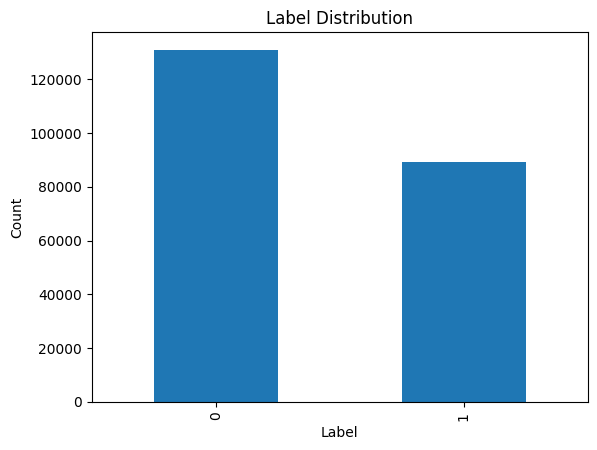

In [71]:
# Plot the distribution of labels
label_counts = labels_df['label'].value_counts()
label_counts.plot(kind='bar')
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

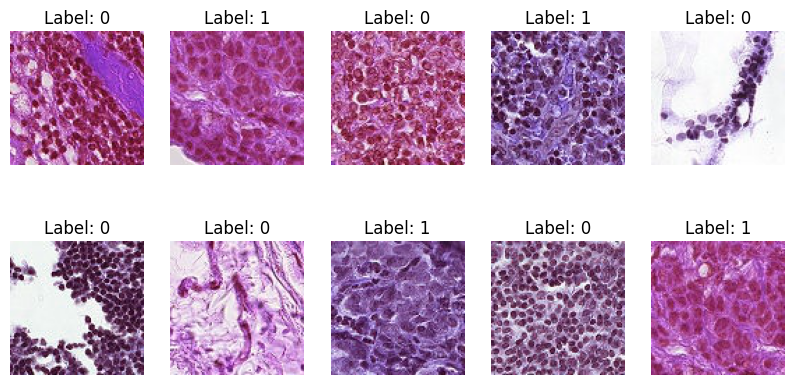

In [72]:
# Plot a few images from the dataset with their labels
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i, ax in enumerate(axes.flat):
    # randomly select an image from the class
    sample_labels_df = labels_df.sample(1)
    img_path = sample_labels_df['id'].values[0]
    label = sample_labels_df['label'].values[0]
    img = cv2.imread(train_dir + f'{img_path}')
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'Label: {label}')

After inspecting the label distributions, it seems there is a slight class imbalance, but not enough to warrant rebalancing at the moment. Also, after inspecting the images, it seems like identifying the presence of cancerous tissue might be a challenge!

## Data Modeling

We will use CNNs to predict the presence of cancerous tissue due to their effectiveness at processing and classifying images and other spacial data.

We will train two CNN models with different architectures and compare their performance. The first model we will train, Model 1, will have 2 convolution layers and 1 dense layer of 128 neurons. The second, Model 2, will have 3 convolution layers and 1 dense layer of 256 neurons. Both models will be trained for 20 epics with early stopping to prevent overfitting.

Although the first model has fewer layers and fewer neurons in it's dense layer, it will have more trainabale parameters than the second model, so it will be interesting to see how they compare.

### Data Preprocessing

Before training the models, we will preprocess the data by resizing the image, normalizing pixel values and splitting the labeled training data into train and validation datasets.

In [73]:
# Rescale pixel values, split for validation, and prepare ImageDataGenerators
image_size = (96, 96)  # Resize to 128x128 (adjust if needed)
batch_size = 32

# Initialize generators for train and validation datasets
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize image pixel values
    validation_split=0.2  # Reserve a portion for validation
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory=train_dir,
    x_col='id',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory=train_dir,
    x_col='id',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=True
)

# Initialize generators for test datasets
# This will be used when submitting predictions to Kaggle
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col='id',
    y_col=None,
    target_size=image_size,
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Found 57458 validated image filenames.


### Model Architecture

#### Model 1

The first model will have 2 convolutional layers with relu activation, 1 dense layer with 128 neurons and relu activation, 1 output layer with 1 neuron and sigmoud activation, and it will use the Adam optimizer. It will have 3,984,577 trainable parameters in total.

In [74]:
# Build simple CNN Model
model_1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_1.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Model summary
model_1.summary()

/Users/kevin.katzmann/.pyenv/versions/data_science/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_35 (Conv2D)              │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,984,577 (15.20 MB)

 Trainable params: 3,984,577 (15.20 MB)

 Non-trainable params: 0 (0.00 B)

#### Model 2

The first model will have 3 convolutional layers with relu activation, 1 dense layer with 256 neurons with relu activation, 1 output layer with 1 neuron with sigmoid activation, and it will use the Adam optimizer. It will have 3,370,561 trainable parameters in total.

In [75]:
# Build advanced CNN Model
model_2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_2.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Model summary
model_2.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_37 (Conv2D)              │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,370,561 (12.86 MB)

 Trainable params: 3,370,561 (12.86 MB)

 Non-trainable params: 0 (0.00 B)

### Training Models

#### Model 1

In [ ]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

history_1 = model_1.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stopping]
)

# Save the model
model_1.save('models/model_1.keras')

Epoch 1/20


/Users/kevin.katzmann/.pyenv/versions/data_science/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 298s 54ms/step - accuracy: 0.7176 - loss: 0.5341 - val_accuracy: 0.8221 - val_loss: 0.4046
Epoch 2/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 292s 53ms/step - accuracy: 0.8209 - loss: 0.4108 - val_accuracy: 0.8225 - val_loss: 0.4015
Epoch 3/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 284s 52ms/step - accuracy: 0.8313 - loss: 0.3869 - val_accuracy: 0.8358 - val_loss: 0.3772
Epoch 4/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 288s 52ms/step - accuracy: 0.8428 - loss: 0.3639 - val_accuracy: 0.8368 - val_loss: 0.3738
Epoch 5/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 286s 52ms/step - accuracy: 0.8541 - loss: 0.3445 - val_accuracy: 0.8468 - val_loss: 0.3531
Epoch 6/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 285s 52ms/step - accuracy: 0.8655 - loss: 0.3225 - val_accuracy: 0.8407 - val_loss: 0.3638
Epoch 7/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 277s 50ms/step - accuracy: 0.8753 - loss: 0.3038 - val_accuracy: 0.8494 - val_loss: 0.3521
Epoch 8/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 277s 50ms/step - accuracy: 0.8853 - lo

#### Model 2

In [ ]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

history_2 = model_2.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stopping]
)

# Save the model
model_2.save('models/model_2.keras')

Epoch 1/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 359s 65ms/step - accuracy: 0.7825 - loss: 0.4678 - val_accuracy: 0.8638 - val_loss: 0.3293
Epoch 2/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 357s 65ms/step - accuracy: 0.8637 - loss: 0.3252 - val_accuracy: 0.8674 - val_loss: 0.3193
Epoch 3/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 349s 63ms/step - accuracy: 0.8822 - loss: 0.2841 - val_accuracy: 0.8942 - val_loss: 0.2637
Epoch 4/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 349s 63ms/step - accuracy: 0.8956 - loss: 0.2575 - val_accuracy: 0.8944 - val_loss: 0.2640
Epoch 5/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 350s 64ms/step - accuracy: 0.9039 - loss: 0.2395 - val_accuracy: 0.8935 - val_loss: 0.2618
Epoch 6/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 347s 63ms/step - accuracy: 0.9113 - loss: 0.2246 - val_accuracy: 0.9047 - val_loss: 0.2423
Epoch 7/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 349s 63ms/step - accuracy: 0.9186 - loss: 0.2055 - val_accuracy: 0.9139 - val_loss: 0.2193
Epoch 8/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 348s 63ms/step - accuracy: 

## Results and Analysis

We will analyze each model by evaluating their accuracy and loss across epochs and by generating predicted labels on the test dataset and submiting them to Kaggle.

#### Model 1

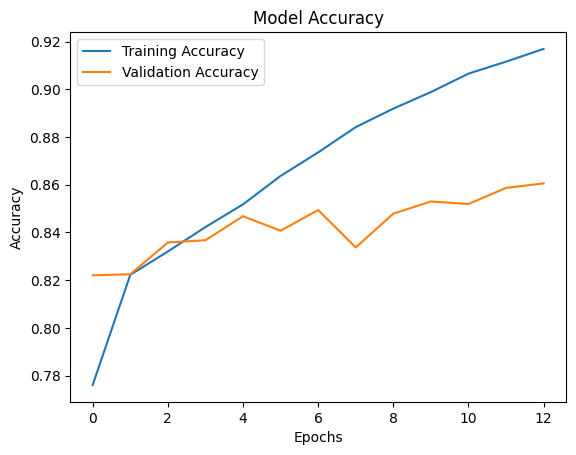

In [ ]:
# Plot training and validation accuracy
plt.plot(history_1.history['accuracy'], label='Training Accuracy')
plt.plot(history_1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model 1 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1376/1376 ━━━━━━━━━━━━━━━━━━━━ 40s 29ms/step - accuracy: 0.8469 - loss: 0.3551
Validation Accuracy: 84.94%


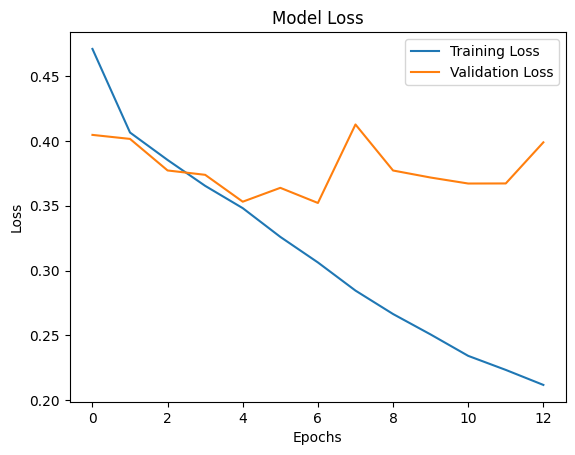

In [ ]:
# Evaluate the model on the validation set
validation_loss, validation_accuracy = model_1.evaluate(val_generator)
print(f'Validation Accuracy: {round((validation_accuracy * 100), 2)}%')

# Plot training and validation loss
plt.plot(history_1.history['loss'], label='Training Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Generate predictions on the test dataset and submit
predictions_1 = model_1.predict(test_generator)

predicted_labels_1 = (predictions_1 > 0.5).astype(int)

submission_df = pd.DataFrame({
    'id': test_generator.filenames,
    'label': predicted_labels_1.flatten()
})

submission_df['id'] = submission_df['id'].apply(lambda x: x.split('/')[-1].replace('.tif', ''))

submission_df.to_csv('output/submission_model_1.csv', index=False)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 58s 32ms/step


Model 1 achieved a validation accuracy of 84.94% and a test accuracy on Kaggle of 80.28%. It completed 12 epochs before there was no incremental improvement in validation loss and the `early_stopping` callback terminated the training. While training accuracy continued to increase until early termination, it is likely that the model would have overfit if the training had carried on for additional epochs.

### Model 2

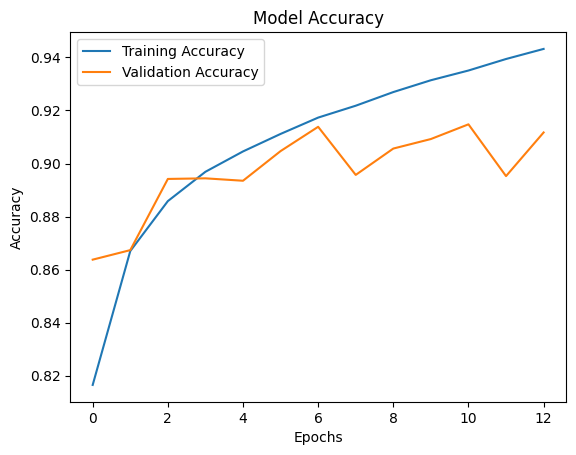

In [54]:
# Plot training and validation accuracy
plt.plot(history_2.history['accuracy'], label='Training Accuracy')
plt.plot(history_2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1376/1376 ━━━━━━━━━━━━━━━━━━━━ 52s 38ms/step - accuracy: 0.9109 - loss: 0.2223
Validation Accuracy: 91.39%


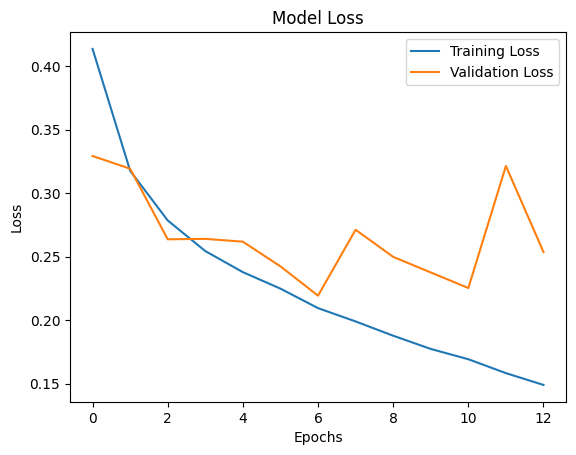

In [64]:
# Evaluate the model on the validation set
validation_loss, validation_accuracy = model_2.evaluate(val_generator)
print(f'Validation Accuracy: {round((validation_accuracy * 100), 2)}%')

# Plot training and validation loss
plt.plot(history_2.history['loss'], label='Training Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Generate predictions on the test dataset and submit
predictions_2 = model_2.predict(test_generator)

predicted_labels_2 = (predictions_2 > 0.5).astype(int)

submission_df = pd.DataFrame({
    'id': test_generator.filenames,
    'label': predicted_labels_2.flatten()
})

submission_df['id'] = submission_df['id'].apply(lambda x: x.split('/')[-1].replace('.tif', ''))

submission_df.to_csv('output/submission_model_2.csv', index=False)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 64s 35ms/step


Model 2 achieved a validation accuracy of 91.39% and a test accuracy on Kaggle of 86.32%. Similar to Model 1, Model 2 completed 12 epochs before there was no incremental improvement in validation loss and the `early_stopping` callback was triggered.

## Conclusion

Although the two CNN architetures are quite similar, it is clear that the additional convolutional layer and larger dense layer in Model 2 provide it with a substantial lift in performance over Model 1, with Model 1 achieving a test accuracy of 86.32% on Kaggle and Model 2 achieveing a test accuracy of 80.28%. Also, early stopping proved to be useful when training both models. However, it is possible that training stopped prematurely and further epochs may have led to improved performance if the models did not overfit to the training data.

Future iterations of this project can consider adjusting a number of model hyperparameters, such as increasing the number of convolutional layers, increasing the number of dense layers, adding dropouts between layers, adjusting the learning rate, and dropping the early stopping callback.